# Segmentation

Segmentation is **the process of partitioning a pointcloud into multiple regions or segments**. 

The list extracted segments provide a higher level of abstraction than a mere collection of 3D points, which may be used later for further analysis or processing. For example, segments may be used for locating and recognizing objects or be replaced by analytic surfaces in a typical reverse engineering process.

This notebook covers three of the most popular "traditional" (i.e., excluding machine/deep learning) algorithms: **Region Growing, the Hough Transform, and RANSAC**.


In [1]:
# Necessary imports
import numpy as np
from scipy import ndimage
from scipy.spatial import KDTree
import matplotlib.pyplot as plt


For the sake of illustration, let's consider a synthetic pointcloud representing an indoor scene, represented below.

This scene is composed of 7 objects and 12 surfaces:
- 1 floor (grey, 1 planar surface)
- 2 walls (yellow, 2 planar surfaces)
- 1 drawer (brown, 4 planar surfaces)
- 1 pipe (grey, 1 cylindrical surface)
- 1 ball (blue, 1 spherical surface)
- 1 stool (red, 1 cylindrical surface, 1 conical surface, and 1 planar surface)


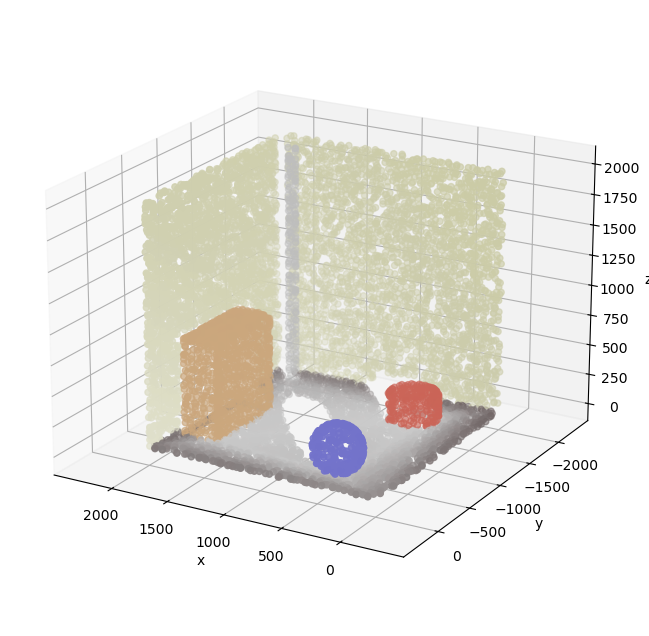

In [2]:
data = np.loadtxt("./data/indoor_scene.xyz")
#points, normals = data[:, :3], data[:, 3:]
points, colors = data[:, :3], data[:, 3:]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          c=colors)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


## Region growing

The region growing algorithm is one quite popular segmentation algorithm, whether for images, pointclouds or meshes. It works by **iteratively aggregating similar points**, in a bottom-up fashion.

This algorithm is fairly simple, with just two main steps:
1. Creation of a region by the selection of a starting element (or *seed*).
2. Growth of this region by incorporating similar elements from its neighborhood.

The growth phase stops when the elements in the region's neighborhood can no longer be incorporated. The algorithm is usually repeated until every point of the pointcloud has been assigned to a region ($n$ repetitions resulting in $n$ regions).

Note that **the algorithm requires the prior definition the notions of similarity and neighborhood**. Numerous indicators may be used to assess similarity, alone or in combination, such as normals, colors, or local curvature. Similarly, the notion of neighborhood may take various definitions, such as k-nearest neighborhood, spherical neighborhood, or planar neighborhood.

An algorithm capable of segmenting a pointcloud into a set of smooth surface patches is for example described in the paper:

Rabbani, T., Van Den Heuvel, F., & Vosselmann, G. (2006). Segmentation of point clouds using smoothness constraint. *International archives of photogrammetry, remote sensing and spatial information sciences*, 36(5), 248-253.

This *smoothness constraint* "uses local surface normals and point connectivity which can be enforced using either k-nearest or fixed distance neighbors". The first is preferred by the authors for its adaptability to local point density.


In [3]:
kdtree = KDTree(points)
def neighbor_finding_function(x): return kdtree.query(x, k=20)[1]
# knn is used here
# for spherical neighborhood: return kdtree.query_ball_point(x, r=10.) 
    

According to the authors, normals are a good and reliable measure of local geometry, unlike principal curvatures and other high order geometrical descriptors which are more sensitive to noise. Normals are estimated by fitting a plane to the local neighborhood of a given point (see the next notebook for more details).

The residual of the plane fitting is taken as an approximation of the local curvature. Indeed, this value is equal to the sum of squared distances between the points and the fitted plane. Hence, the higher the residual, the more the surface sampled by the points deviate from a plane.

Note that both normals and residuals are affected by the kind and the size of the considered local neighborhood.


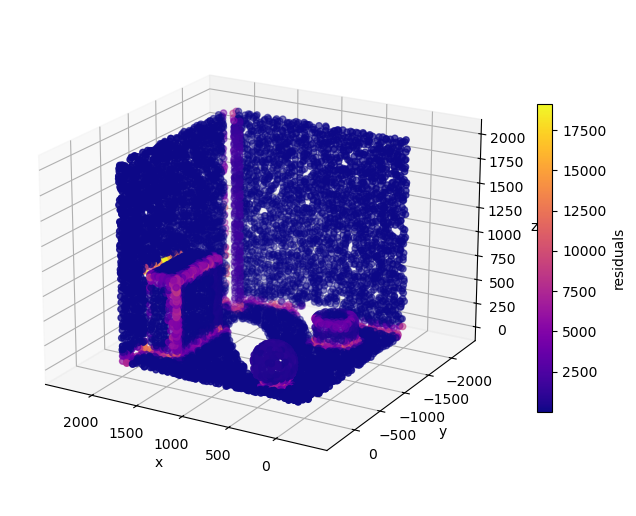

In [4]:
def compute_normals_residuals(points, neighbor_finding_function):

    normals = np.empty(points.shape, dtype=float)
    residuals = np.empty(len(points), dtype=float)

    # Local connectivity
    neighbors = neighbor_finding_function(points)
    # Local plane fitting
    for j, inds in enumerate(neighbors):    
        centroid = points[inds].mean(axis=0)
        X = points[inds] - centroid
        cov = X.T @ X
        w, v = np.linalg.eigh(cov)
        residuals[j] = w[0]
        normals[j] = v[:, 0] # eigenvectors are normalized

    return normals, residuals


# Compute and plot residuals
normals, residuals = compute_normals_residuals(points, neighbor_finding_function)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
p = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          c=residuals, cmap="plasma")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 120)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('residuals')
plt.axis("equal")
plt.show()
    

The estimated normals and residuals are then used for the region growing process:
1. The neighbor $p_j$ of $p_i$ is added to the growing region only if the cosine of the angle between their normals is over given threshold: $|n_i \cdot n_j| > \cos(\theta_{th})$
2. A neighbor of $p_j$ is considered a suitable candidate for the next steps of the growing phase only if its residual is below a given threshold: $r_j < r_{th}$

In the first expression, the absolute value of the dot product is taken due to inconsistent orientation between normals (normals are estimated with a 180° ambiguity). Normals are also supposed to be unit vectors.

The authors of the article propose to use an absolute value for $\theta_{th}$ and a relative value for $r_{th}$, which is a less intuitive parameter.


In [5]:
# Angle threshold (in degrees)
angle_threshold = 15.
# Residual threshold (as a percentile of the plane residuals)
residual_threshold = np.percentile(residuals, 95)


Once the neighborhood and thresholds have been defined and the normals and residuals have been approximated, the region growing phase may begin. The seed is here chosen as the not-already-segmented point with the minimum residual and the growth phase is realized according to the angular and residual conditions described above.

The process stops when each point of the pointcloud has been attributed to a segment/region.


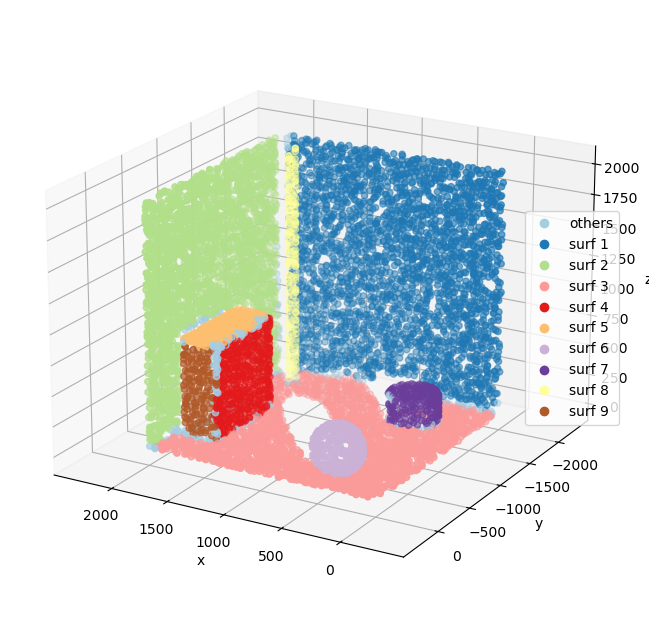

In [6]:
def region_growing(points, normals, residuals, neighbor_finding_function, angle_threshold, residual_threshold):
    
    # All points are available at start
    available_points = np.ones(len(points), dtype=bool)
    regions = []

    while available_points.any():
    
        # Current region is empty
        current_region = np.zeros(len(points), dtype=bool)
        # Point (index) with minimal residual is chosen as seed
        remaining_points = np.flatnonzero(available_points)
        seed = remaining_points[np.argmin(residuals[available_points])]
        current_seeds = [seed] # works as a queue
        # Remove seed from available points
        available_points[seed] = False
        # Include seed to current region
        current_region[seed] = True
    
        while len(current_seeds):        
            # Find nearest neighbors of current seed point
            seed = current_seeds.pop(0)
            neighbors = neighbor_finding_function(points[seed])
            
            for neighbor in neighbors:
                
                # Neighbors with orientation close to the seed are added to the current region
                abs_cos = np.abs(normals[neighbor] @ normals[seed]).clip(0., 1.) # absolute value because normals have a 180° ambiguity 
                angle = np.arccos(abs_cos) * 180/np.pi # in degrees
                if available_points[neighbor] and (angle < angle_threshold):
                    current_region[neighbor] = True
                    available_points[neighbor] = False
                    
                    # Neighbors with small residuals are potential seeds
                    if residuals[neighbor] < residual_threshold:
                        current_seeds.append(neighbor)
    
        regions.append(np.flatnonzero(current_region))

    return sorted(regions, key=len, reverse=True) # sort according to region size


# Segment pointcloud using region growing
regions = region_growing(points, normals, residuals, neighbor_finding_function, angle_threshold, residual_threshold)    

# Attribute a label to each point (number of attributed region)
labels = np.zeros(len(points))
for i, r in enumerate(regions):
    if len(r) < 100: break # disregard small regions for vizualisation purpose
    labels[r] = i + 1
classes = ["surf {}".format(i) for i in range(len(np.unique(labels)))]
classes[0] = "others"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
s = ax.scatter(points[:, 0], points[:, 1], points[:,2],
               c=labels, cmap="Paired")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right", handles=s.legend_elements()[0], labels=classes)
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


Here, small neighborhoods and small thresholds (i.e., small values of $\theta_{th}$ and $r_{th}$) would likely lead to over-segmentation (i.e., more segmented surfaces), and vice-versa.

In a nutshell, the region-growth algorithm is relatively simple to conceptualize and implement. However, its results depend on the a priori definition of a neighborhoods and similarity criteria. Its parameters (size of the neighborhood and thresholds used to define the notion of similarity) need to be adjusted according to the context (pointcloud density, presence of noise, etc.).


## The Hough Transform

The Hough Transform is a technique used for detecting parametric shapes. It was introduced in the patent:

Hough, P. V. C. (1962) *Method and Means for Recognizing Complex Patterns*, US Patent 3069654.

Its first application dealt with line detection in 2D images. It was later successfully extended to other 2D shapes, such as circles, but also to 3D shapes.

The Hough Transform **expresses any data point in the parameter space of the to-be-detected shape**. The computation of every set of parameters compatible with this data point gives a unique $m$-dimensional shape in the Hough space. As a result, the location of the point of intersection of $m$ or more shapes in the Hough space gives the parameters of the shape connecting the corresponding data points in the original space.

Let's consider an infinite planar surface for the sake of the example. This plane is often described by its cartesian equation $a.x + b.y + c.z + d = 0$, with the first three parameters denoting its orientation (or normal) and the last one its signed distance to the origin. Switching to spherical coordinates leads to the much less often encountered equation $x.\cos(\theta).\sin(\phi) + y.\sin(\theta).\sin(\phi) + z.\cos(\phi) = \rho$. This has however the double advantage of reducing the number of parameters and also the parameter space. Indeed, the three parameters defining the orientation of the plane $a$, $b$ and $c$ have potentially infinite bounds (in practice unit normal vectors are often considered) while the two parameters $\theta$ and $\phi$ have finite bounds.

Regarding the parameter $\rho$, also note that its absolute value cannot exceed the distance to origin of the furthest point of the pointcloud. To put it simply: $|\rho| \leq \max \sqrt{x_i^2 + y_i^2 + z_i^2}$. As a proof, consider that $|d| = |ax_i + by_i + cy_i| = |n \cdot p_i|$, with $n = (a, b, c)$ the plane normal and $p_i$ the point of the pointcloud through which the plane passes. Using the Cauchy-Schwarz inequality, we deduce that $|p \cdot n| \leq ||p||~||n|| = ||p||$ (as $||n|| = 1$ here with our switch to spherical coordinates).

As a result, a plane is usually described in a 3-dimensional Hough space with dimensions $\rho$, $\theta$, and $\phi$. This means that a point $q_j = [\rho_j, \theta_j, \phi_j]$ in the Hough space corresponds to a plane of equation $x.\cos(\theta_j).\sin(\phi_j) + y.\sin(\theta_j).\sin(\phi_j) + z.\cos(\phi_j) = \rho_j$ in the 3D space. On the opposite, in the 3D space, a point $p_i = [x_i, y_i, z_i]$ belongs to an infinite number of planes that verify the equation $x_i.\cos(\theta).\sin(\phi) + y_i.\sin(\theta).\sin(\phi) + z_i.\cos(\phi) = \rho$. Translating this in the Hough space results in drawing a three-dimensional sinusoid curve, like the ones shown below.

The Hough transform is then used to embed all $n$ points of the pointcloud in the Hough space, resulting in one sinusoid curve per point. The intersection of three curves in the Hough space corresponds to the coordinates defining the plane spanned by the three corresponding points. Of course, the more curves intersect the more points belong to this plane in the 3D space.


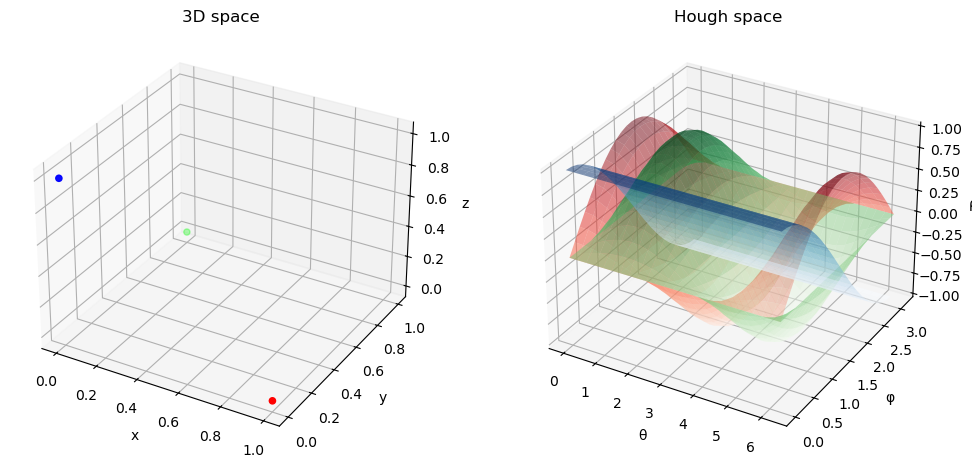

In [7]:
def sample_hough_sinusoid_curve(point, n_theta=25, n_phi=25):
    """Build the unique sinusoid curve in the Hough space for a given point"""

    # Grid with theta and phi
    thetas = np.linspace(0., 2*np.pi, n_theta)
    phis = np.linspace(0., np.pi, n_phi)
    X, Y = np.meshgrid(thetas, phis)
    # Corresponding rho values
    ax = point[0] * np.cos(X) * np.sin(Y)
    by = point[1] * np.sin(X) * np.sin(Y)
    cz = point[2] * np.cos(Y)
    Z = ax + by + cz
    
    return X, Y, Z


# Example with three point
points_hough_example = np.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])
X, Y, Z_0 = sample_hough_sinusoid_curve(points_hough_example[0])
_, _, Z_1 = sample_hough_sinusoid_curve(points_hough_example[1])
_, _, Z_2 = sample_hough_sinusoid_curve(points_hough_example[2])

fig = plt.figure(figsize=(12, 8))
ax_0 = fig.add_subplot(121, projection="3d")
ax_0.scatter(points_hough_example[:, 0], points_hough_example[:, 1], points_hough_example[:, 2], c=points_hough_example)
ax_0.set_xlabel('x')
ax_0.set_ylabel('y')
ax_0.set_zlabel('z')
ax_0.set_title("3D space")
ax_1 = fig.add_subplot(122, projection="3d")
ax_1.plot_surface(X, Y, Z_0, cmap="Reds", alpha=.5)
ax_1.plot_surface(X, Y, Z_1, cmap="Greens", alpha=.5)
ax_1.plot_surface(X, Y, Z_2, cmap="Blues", alpha=.5)
ax_1.set_xlabel('θ')
ax_1.set_ylabel('φ')
ax_1.set_zlabel('ρ')
ax_1.set_title("Hough space")
plt.show()


Consequently, **detecting 3D planes with this technique involves finding intersections between sinusoid curves in Hough space**. Of course, the more curves are present at this intersection, the better. However, computing the intersections between $n$ curves (one per point) is in practice very computationally expensive. Moreover, points are likely to be affected by noise, which makes it almost impossible that several curves intersect at the exact same point in the Hough space.

In practice, the Hough space is discretized into $n_{\rho} * n_{\theta} * n_{\phi}$ cells or bins. Each bin is assigned a score representing the number of curves that pass through or, in other words, the number of points of the pointcloud that are compatible with the underlying plane parameters (with a tolerance due to discretization). For this reason, the underlying data structure (similar to a voxel grid here) is called the *accumulator*. As a result, **the shape detection process may be assimilated to a voting process, during which every data point "votes" for all sets of parameters that define a compatible plane**. In the end, the bins with the highest scores represent the planes compatible with the largest number of points.

Note that the size of the accumulator, which is usually an array of shape $(n_{\rho}, n_{\theta}, n_{\phi})$, has a direct impact on the plane detection process. Indeed, the larger this size, the smaller the cells, and the greater the chances of detecting different planes sharing almost the same parameters. However, the larger the accumulator size, the larger its memory footprint and the computation time required to fill it. For instance, choosing $n_{\theta} = 360$ and $n_{\phi} = 180$ so that $\theta_{step} = \phi_{step} = \pi/180$ results in $64800 * n_{\rho}$ cells. Consequently, a tradeoff must be found between the quality of the output of the detection process and the use of computational resources. In case the size of the accumulator cannot be reduced, using smaller unsigned integer types or a sparse matrix are some simple tricks to reduce its memory footprint.

Below is a tentative to detect the most important planes in our pointcloud thanks to the Hough Transform.


The accumulator consists of 49973640 cells, of which 17255214 are not empty
The best 10 bins are: [(47, 0, 3413), (18, 60, 3413), (97, 0, 3413), (115, 0, 3413), (41, 0, 3413), (65, 0, 3413), (0, 30, 5413), (30, 30, 1413), (60, 30, 1413), (90, 30, 5413)]
Detected (cartesian) planes are: [(-0.0, 0.0, 1.0, 0.0), (7.198293278059966e-17, 9.907600726170916e-17, -1.0, 0.0), (0.0, -0.0, 1.0, 0.0), (0.0, -0.0, 1.0, 0.0), (-0.0, 0.0, 1.0, 0.0), (-0.0, -0.0, 1.0, 0.0), (1.0, 0.0, 6.123233995736766e-17, 2000.0), (6.123233995736766e-17, 1.0, 6.123233995736766e-17, -2000.0), (-1.0, 1.2246467991473532e-16, 6.123233995736766e-17, -2000.0), (-1.8369701987210297e-16, -1.0, 6.123233995736766e-17, 2000.0)]


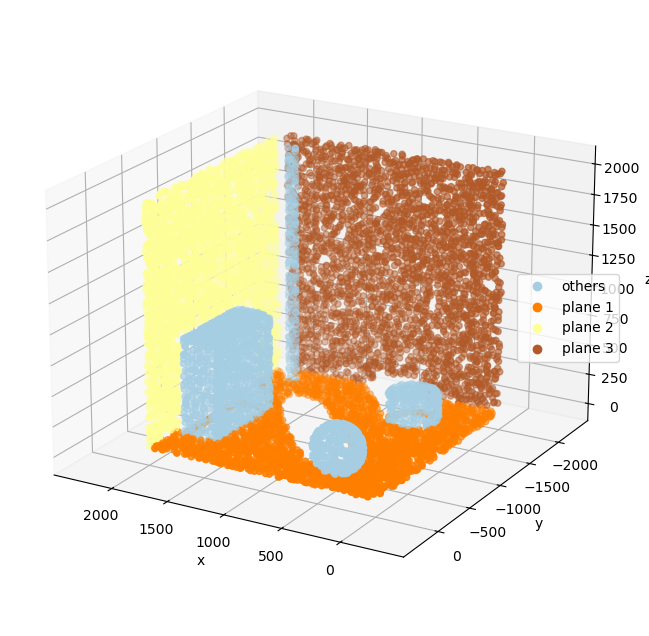

In [8]:
def hough_transform_plane(points, n_theta=120, n_phi=61, n_rho=None):
    """Plane Hough Transform"""
    
    # Angles at which to compute the transform
    theta_values = np.linspace(0., 2*np.pi, n_theta, endpoint=False) # theta in [0., 2*pi[
    phi_values = np.linspace(0., np.pi, n_phi) # phi in [0., pi]

    # Compute the bins, unit size by default (n_rho=None)
    rho_max = np.max(np.linalg.norm(points, axis=1))
    if n_rho is None:
        rho_max = np.ceil(rho_max).astype(int)
        offset = rho_max
        n_rho = 2*offset + 1 # corresponds to int max distance
    else:
        offset = int((n_rho - 1)/2)
    rho_values, rho_step = np.linspace(-rho_max, rho_max, n_rho, retstep=True) # rho in [-rho_max, rho_max]

    # Allocate the accumulator array
    accumulator = np.zeros(
        (n_theta, n_phi, n_rho),
        dtype=np.uint16 # Use ushort to reduce memory footprint (/!\ count up to 65535 only!)
    )
    
    # Precompute normals to speed-up computation
    i = np.tile(np.arange(n_theta), n_phi) # grid indices for theta
    j = np.repeat(np.arange(n_phi), n_theta) # grid indices for phi
    normals = np.vstack([
        np.cos(theta_values[i]) * np.sin(phi_values[j]),
        np.sin(theta_values[i]) * np.sin(phi_values[j]),
        np.cos(phi_values[j])
    ])
    
    # Fill accumulator by computing rho values associated with (theta, phi) for each point
    for point in points:
        # Vectorized form of rho = a.x + b.y + c.z
        rho_calc = point @ normals
        # Compute the grid index associted with rho_calc
        k = np.round(rho_calc/rho_step).astype(int)
        # Make k (index) start at 0
        k += offset
        # Increment bins
        accumulator[i, j, k] += 1

    return accumulator, theta_values, phi_values, rho_values


# Transform our pointcloud
accumulator, theta_values, phi_values, rho_values = hough_transform_plane(points)
print(f"The accumulator consists of {accumulator.size} cells,",
      f"of which {np.count_nonzero(accumulator)} are not empty")

# Find the bins with the highest scores
n_best = 10
best_bins = [np.unravel_index(ind, accumulator.shape) 
             for ind in np.argpartition(accumulator.flatten(), -n_best)[-n_best:]]
print(f"The best {n_best} bins are: {best_bins}")

# Retrieve the parameters of the the detected planes
best_params = [
    (theta_values[b[0]], phi_values[b[1]], rho_values[b[2]])
    for b in best_bins
]
best_planes = [
    (np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi), rho)
    for theta, phi, rho in best_params
]
print(f"Detected (cartesian) planes are: {best_planes}")

# Plot
labels = np.zeros(len(points))
for i, plane_equation in enumerate(best_planes):
    
    dists = np.abs(points @ plane_equation[:3] - plane_equation[3])
    inliers = dists < 1. # Adjust in function of rho_step
    labels[inliers] = i + 1


classes = ["plane {}".format(i) for i in range(len(np.unique(labels)))]
classes[0] = "others"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
s = ax.scatter(points[:, 0], points[:, 1], points[:,2],
               c=labels, cmap="Paired")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right", handles=s.legend_elements()[0], labels=classes)
ax.view_init(20, 120)
plt.axis("equal")
plt.show()



As shown above, the result is quite disappointing as the detection process returns a set of identical planes.

These planes correspond to adjacent cells in the accumulator, materialized by two vertical lines, as shown below. In this particular example, bins with the highest score correspond to parameters $\rho = 0$ and $\phi = 0 \pm \pi$, which corresponds to planes with equations $z = 0$ (note that the parameter $\theta$ doesn't come into play as $\cos \phi = 0$).


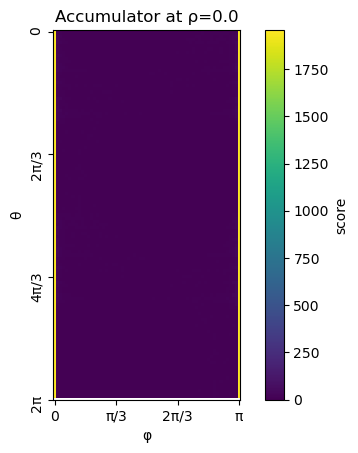

In [9]:
# Show accumulator values for layer rho_index
rho_index = 3413

fig, ax = plt.subplots()
im = ax.imshow(accumulator[:,:,rho_index], cmap='viridis')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('score')
ax.set_xticks(np.linspace(0, len(phi_values)-1, 4))
ax.set_xticklabels(["0", "π/3", "2π/3", "π"], rotation=0)
ax.set_xlabel('φ')
ax.set_yticks(np.linspace(0, len(theta_values), 4))
ax.set_yticklabels(["0", "2π/3", "4π/3", "2π"], rotation=90)
ax.set_ylabel('θ')
ax.set_title(f"Accumulator at ρ={rho_values[rho_index]}")
plt.show()


The above example underlines that maximum values or peaks are often spread around adjacent bins representing in fact a single plane. This may be due to parametrization, as illustrated here, but also often to discretization and noise. Indeed, if bins are too small or if points are affected by a large amount of noise, some votes are likely miss the "right" bin and fall into neighboring bins instead. 

This is why, it is advised to **not search for the best bins but for groups of adjacent bins with high scores instead**. A popular solution consists in refining the result of the Hough Transform with Non-Maximum Suppression. This technique basically relies on a notion of minimum distance separating peaks in each dimension.

A simplified implementation of this technique is given below.


In [10]:
def peak_window(accumulator, size_theta=5, size_phi=5, size_rho=3, threshold=None):
    """Use a sliding window technique to filter out the maxima in the accumulator
    that are close to each other."""

    acc = accumulator.copy()
    n_theta, n_phi, n_rho = acc.shape
    
    # Threshold is set to half the max value of the accumulator by default
    if threshold is None:
        threshold = 0.5 * np.max(accumulator)

    # Slide the window and only keep the maximum value
    acc_max = ndimage.maximum_filter(acc, size=(size_theta, size_phi, size_rho), mode="constant")
    mask = (acc == acc_max)
    acc *= mask

    # Only keep peaks above the treshold
    acc[acc < threshold] = 0

    return acc


# Apply our peak detection
new_accumulator = peak_window(accumulator)

# Find the bins with the highest scores
n_best = 10
best_bins = [np.unravel_index(ind, new_accumulator.shape) 
             for ind in np.argpartition(new_accumulator.flatten(), -n_best)[-n_best:]]
print(f"The best {n_best} bins are: {best_bins}")

# Retrieve the parameters of the the detected planes
best_params = [
    (theta_values[b[0]], phi_values[b[1]], rho_values[b[2]])
    for b in best_bins
]
best_planes = [
    (np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi), rho)
    for theta, phi, rho in best_params
]
print(f"Detected (cartesian) planes are: {best_planes}")


The best 10 bins are: [(14, 60, 3413), (69, 0, 3413), (7, 60, 3413), (45, 0, 3413), (39, 0, 3413), (90, 30, 5413), (30, 30, 1413), (0, 30, 5413), (87, 60, 3413), (60, 30, 1413)]
Detected (cartesian) planes are: [(9.100899318238094e-17, 8.194486552889032e-17, -1.0, 0.0), (-0.0, -0.0, 1.0, 0.0), (1.143306281056419e-16, 4.388741623276521e-17, -1.0, 0.0), (-0.0, 0.0, 1.0, 0.0), (-0.0, 0.0, 1.0, 0.0), (-1.8369701987210297e-16, -1.0, 6.123233995736766e-17, 2000.0), (6.123233995736766e-17, 1.0, 6.123233995736766e-17, -2000.0), (1.0, 0.0, 6.123233995736766e-17, 2000.0), (-1.9157696688784747e-17, -1.2095693648649962e-16, -1.0, 0.0), (-1.0, 1.2246467991473532e-16, 6.123233995736766e-17, -2000.0)]


Numerous variants of the Hough transform for plane detection have been proposed over the years to improve its performance. The article below provides a good summary:

Borrmann, D., Elseberg, J., Lingemann, K., & Nüchter, A. (2011). The 3D Hough Transform for plane detection in point clouds: A review and a new accumulator design. *3D Research*, 3(2), 1-13.

However, its extension to other 3D shapes remains quite difficult. This is mostly due to the higher number of parameters necessary for their description, which increases the dimensionality of the corresponding Hough space and results in a prohibitively high time and space complexity of the algorithm for most practical applications (this is also known as the curse of dimensionality).

Note that some tricks may be used to mitigate this aspect, as for example estimating the shape parameters in a sequential manner. This was successfully applied to cylinder detection, where a first 2D Hough Transform is used to estimate the cylinder orientation and a second 3D Hough Transform is used to estimate its position and radius. More details may be found in the paper:

Rabbani, T., & Van Den Heuvel, F. (2005). Efficient Hough Transform for Automatic Detection of Cylinders in Point Clouds. *In Proceedings of the ISPRS Workshop "Laser Scanning 2005"*, 60-65.

Nevertheless, this exception seems to confirm the general rule that the Hough transform is not suited for the detection of most complex 3D shapes.

To sum up, the Hough Transform may be adapted to detect simple shapes such as planes in pointclouds. It is a relatively simple algorithm that is theoretically capable of detecting all the planes in the pointcloud at once (without needing to be iteratively applied). However, a tradeoff must be found between the precision of the algorithm (via the finesse of parameter space discretization) and the use of computing resources. Some post-processing steps may also be required to eliminate similar detected shapes.


## RANSAC

The Random sample consensus (RANSAC) algorithm aims to estimate the parameters of a *model* from a dataset that contains outliers. It was introduced in the paper:

Fischler, M. A., & Bolles, R. C. (1981). Random sample consensus: a paradigm for model fitting with applications to image analysis and automated cartography. *Communications of the ACM*, 24(6), 381-395.

The basic algorithm consists in two steps, that are iteratively repeated:
1. Randomly draw a sample of minimum but sufficient size from the dataset to build a candidate model
2. Compute the score of this candidate model by estimating the number of elements of the dataset that are consistent with it

The best candidate model is kept after a given number of iterations.

The RANSAC algorithm has many applications, including finding geometrical shapes in pointclouds. As for models (in general), these shapes have parameters and a measure of "how far" they are from the data points. **The RANSAC algorithm therefore generates multiple candidate shapes from a few randomly selected points to only keep the "best shape" in the end**. It relies on the fact that generating and evaluating a candidate shape is computationally inexpensive and can be repeated a large number of times.

Let's consider an infinite planar surface, described by its cartesian equation $a.x + b.y + c.z + d = 0$,  for the sake of the example. The parameters of the plane ($a$, $b$, $c$, and $d$) may be estimated using 3 points only: $n = [a, b, c] = (p_1 - p_0) \times (p_2 - p_0)$ and $d = - p_i \cdot n, \quad i = 0, 1, 2$. The distance between a point $p$ and the plane is given by $d = | n \cdot p + d |$ with $|| n || = 1$.


In [11]:
class PlaneModel:

    min_sample_size = 3
    
    def __init__(self):

        self.parameters = [1., 0., 0., 0.] # a.x + b.y + c.z + d

    def estimate_parameters(self, points):

        v1, v2 = points[1, :] - points[0, :], points[2, :] - points[0, :]
        self.parameters[:3] = np.cross(v1, v2) / np.linalg.norm(np.cross(v1, v2))
        self.parameters[-1] = - points[0, :] @ self.parameters[:3]

    def compute_distance(self, points):

        return np.abs(points @ self.parameters[:3] + self.parameters[-1])

    

A given number of candidate planes are evaluated before the best candidate is returned. Inliers are defined as points within a certain distance (threshold) to a candidate plane.

The algorithm then is usually repeated a certain number of times in order to detect all shapes present in the pointcloud.


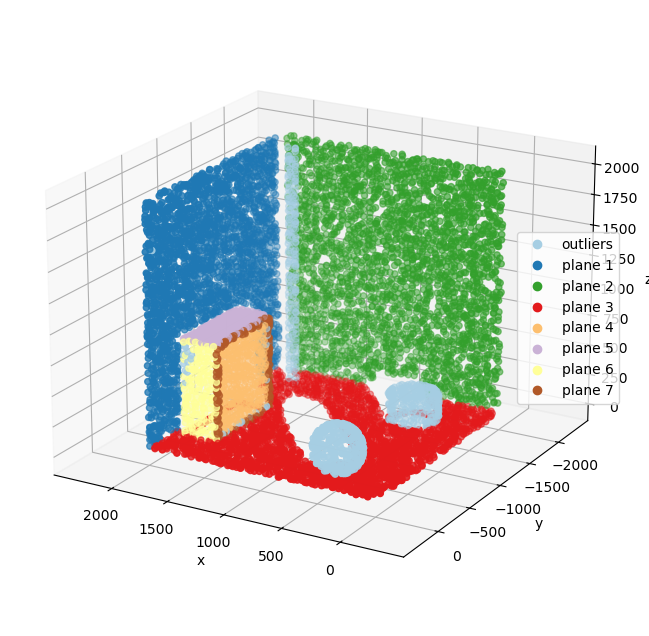

In [12]:
def RANSAC(points, model, n_draws, threshold):

    best_score = 0
    best_model = None
    best_inliers = None

    for _ in range(n_draws):
        # Random sampling
        sampled_inds = np.random.choice(len(points), size=model.min_sample_size, replace=False)
        sampled_points = points[sampled_inds]
        # Candidate plane
        candidate = model()
        candidate.estimate_parameters(sampled_points)
        # Inliers
        dists = candidate.compute_distance(points)
        inliers = np.flatnonzero(dists < threshold)
        # Score
        score = len(inliers)
        # Keep best candidate
        if score > best_score:
            best_score = score
            best_model = candidate
            best_inliers = inliers

    return best_model, best_score, best_inliers


# Run RANSAC for planar surfaces
max_number_of_runs = 100
min_points_per_region = 100 # disregard small regions

all_regions = []
remaining_inds = np.arange(len(points), dtype=int)
for _ in range(max_number_of_runs):
    _, _, region = RANSAC(points[remaining_inds], PlaneModel, 100, .1)
    if len(region) > min_points_per_region:
        all_regions.append(remaining_inds[region])
        remaining_inds = np.setdiff1d(remaining_inds, remaining_inds[region])

# Attribute a label to each point (number of attributed region)
labels = np.zeros(len(points))
for i, r in enumerate(all_regions):
    labels[r] = i+1
classes = ["plane {}".format(i) for i in range(len(np.unique(labels)))]
classes[0] = "outliers"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
s = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
              c=labels, cmap="Paired")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right", handles=s.legend_elements()[0], labels=classes)
ax.view_init(20, 120)
plt.axis("equal")
plt.show()


As seen above, the algorithm successfully detect planar surfaces in the pointcloud. Again, the parameters of the algorithm can be adjusted according to the segmentation result: a small number of repetitions and a small value of the distance threshold would likely lead to under-segmentation, and vice-versa.

The above example describes a very simple implementation of the RANSAC algorithm, but many proposals have been made to improve its the behavior in the context of shape detection in pointclouds. Some major ones are described in the article:

Schnabel, R., Wahl, R., & Klein, R. (2007, June). Efficient RANSAC for point‐cloud shape detection. In *Computer graphics forum* (Vol. 26, No. 2, pp. 214-226). Oxford, UK: Blackwell Publishing Ltd.

Covered aspects include shape estimation (i.e., the process of estimating the parameters of planes, cylinders, spheres, cones and tori from minimal sets of oriented points), complexity (i.e., the number of candidates required to detect shapes with sufficient probability), sampling strategy, scoring (using a distance threshold but also an angular threshold and taking points connectivity into account), and refitting.

More generally, the popularity of the RANSAC algorithm for shapes detection in pointclouds lies in its simplicity, extensibility to a wide variety of shapes (as long as an estimation function from a minimal set of points and a distance function are available) and robustness to the presence of outliers. However, it is quite computationally demanding and non-deterministic (i.e., different runs may give different results).



## Wrapping up

You should now have a better grasp of some of the most popular "traditional" segmentation algorithms, i.e., Region Growing, the Hough Transform, and RANSAC. Unlike newer learning algorithms, these rely solely on geometrical reasoning and *a priori* assumptions about the segments to be found. This leads to group points that appear to belong to locally smooth surfaces in case of Region Growing or to geometric primitives in case of the Hough Transform or RANSAC.

In short, Region Growing is a fairly simple algorithm that only requires a certain degree of smoothness of the underlying surface and guarantees that the segmented points are all within a certain predefined distance from each other. The fact that it operates at a local scale makes it rather sensitive to the presence of occlusions, noise and outliers. In constrast, the Hough Transform is more complex but also more robust and capable of detecting all shapes at once. It is in practice mostly adapted to planar shapes and may require consequent computational resources and additional post-processing steps to ensure the result consistency. Finally, RANSAC is a simple but robust algorithm that can be extended to detect many types of parametric shapes. It is, however, non-deterministic, quite computationally expensive due to its iterative nature, and has many parameters to tune in its most advanced form.

A first key takeaway is that all these techniques are likely to achieve mediocre to good results, depending on the complexity and the quality of the considered pointcloud. This is because they are based on quite simple assumptions and reasoning (e.g., variation of orientation between neighboring points is enough to capture surface smoothness) and on an estimation of the pointcloud characteristics (density, noise, etc.). These results may, however, be sufficient for further processing tasks.

These tasks often include classification and fitting, i.e., finding the surface associated with each segment and its parameters (see next notebook for more information). Another takeaway is that segmentation, classification and fitting are not independent. As stated before, all techniques described above make assumptions about the underlying surfaces of the segment (whether they are smooth surfaces, planes, cylinders, etc.). Both the Hough Transform and RANSAC also give an estimation of the parameters of these surfaces (that may be refined later, again see next notebook). Consequently, iterations between the segmentation, classification and fitting steps or manual rework are often needed to converge towards the desired result.

All these reasons partly explain the recent shift from these "traditional" segmentation algorithms to machine and deep learning algorithms. The latter are indeed capable of segmenting and classifying points according to more global or abstract criteria. This is the topic of a future notebook.
